In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

from hmmlearn.hmm import GaussianHMM

df = pd.read_csv("../data/nifty_model_features.csv")

df.head()


,Datetime,Close,High,Low,Open,Volume,EMA_5,EMA_15,Returns
0,2025-10-24 03:50:00+00:00,25886.000000,25892.400391,25840.400391,25851.150391,0.0,25862.533854,25855.200684,0.001362
1,2025-10-24 03:55:00+00:00,25886.400391,25893.300781,25859.500000,25886.300781,0.0,25870.489366,25859.100647,0.000015
2,2025-10-24 04:00:00+00:00,25875.400391,25887.599609,25864.500000,25885.849609,0.0,25872.126374,25861.138115,-0.000425
3,2025-10-24 04:05:00+00:00,25914.300781,25914.699219,25862.550781,25876.150391,0.0,25886.184510,25867.783448,0.001503
4,2025-10-24 04:10:00+00:00,25903.500000,25913.300781,25883.449219,25913.199219,0.0,25891.956340,25872.248017,-0.000417


inputs for HMM

In [2]:
df["Volatility"] = df["Returns"].rolling(20).std()

df = df.dropna().reset_index(drop=True)

X = df[["Returns", "Volatility"]].values

X[:5]


array([[ 4.65140517e-05,  7.64033847e-04],
       [-1.41350763e-04,  6.88065718e-04],
       [-4.00815185e-04,  6.89896331e-04],
       [ 6.29575298e-04,  7.07488955e-04],
       [-4.24015346e-04,  6.02036296e-04]])

Hidden Markov Model

In [3]:
hmm = GaussianHMM(
    n_components=3,
    covariance_type="full",
    n_iter=200,
    random_state=42
)

hmm.fit(X)

df["HMM_State"] = hmm.predict(X)

df["HMM_State"].value_counts()


Model is not converging.  Current: 49007.902119001206 is not greater than 49008.36800178777. Delta is -0.4658827865641797


HMM_State
1    4204
0      27
2       1
Name: count, dtype: int64

HMM states to market regimes mapping

In [4]:
state_means = df.groupby("HMM_State")["Returns"].mean()

state_means


HMM_State
0   -0.000549
1    0.000004
2   -0.005545
Name: Returns, dtype: float64

In [5]:
state_map = {
    state_means.idxmax(): "Uptrend",
    state_means.idxmin(): "Downtrend"
}

df["HMM_Regime"] = df["HMM_State"].map(state_map).fillna("Sideways")

df["HMM_Regime"].value_counts()


HMM_Regime
Uptrend      4204
Sideways       27
Downtrend       1
Name: count, dtype: int64

HMM regimes on price

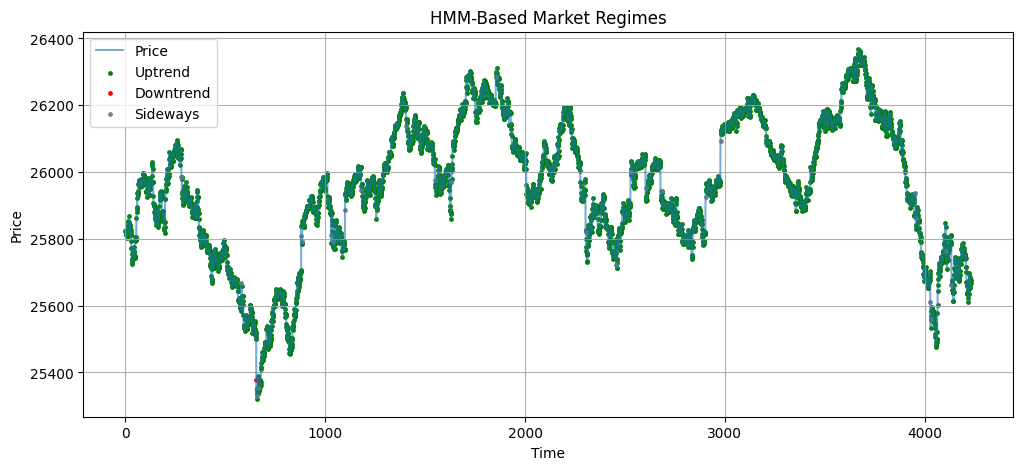

In [6]:
plt.figure(figsize=(12, 5))
plt.plot(df["Close"], label="Price", alpha=0.6)

colors = {
    "Uptrend": "green",
    "Downtrend": "red",
    "Sideways": "gray"
}

for regime, color in colors.items():
    mask = df["HMM_Regime"] == regime
    plt.scatter(df.index[mask], df["Close"][mask],
                color=color, s=6, label=regime)

plt.title("HMM-Based Market Regimes")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()


HMM-filtered EMA strategy

In [7]:
df["HMM_Signal"] = 0

df.loc[
    (df["EMA_5"] > df["EMA_15"]) & (df["HMM_Regime"] == "Uptrend"),
    "HMM_Signal"
] = 1

df.loc[
    (df["EMA_5"] < df["EMA_15"]) & (df["HMM_Regime"] == "Downtrend"),
    "HMM_Signal"
] = -1

df["HMM_Return"] = df["HMM_Signal"].shift(1) * df["Returns"]
df["HMM_Cumulative"] = (1 + df["HMM_Return"]).cumprod()

df[["HMM_Cumulative"]].tail()


,HMM_Cumulative
4227,0.990308
4228,0.989526
4229,0.989526
4230,0.989526
4231,0.989526


Outlier trade analysis

In [8]:
trade_returns = df["HMM_Return"].dropna()

z_scores = (trade_returns - trade_returns.mean()) / trade_returns.std()

df_trades = df.loc[trade_returns.index].copy()
df_trades["Z_Score"] = z_scores

outliers = df_trades[abs(df_trades["Z_Score"]) > 3]

len(outliers), len(df_trades)


(88, 4231)

Visualize outlier trades

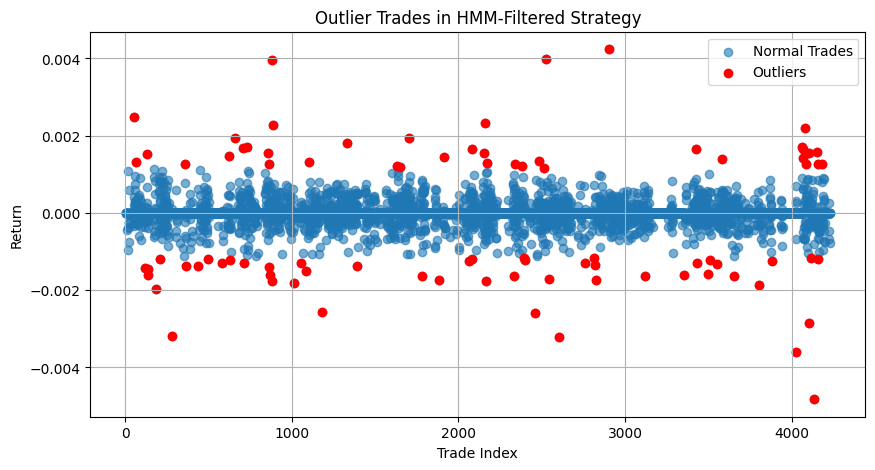

In [9]:
plt.figure(figsize=(10, 5))
plt.scatter(df_trades.index, df_trades["HMM_Return"], label="Normal Trades", alpha=0.6)
plt.scatter(outliers.index, outliers["HMM_Return"],
            color="red", label="Outliers")

plt.xlabel("Trade Index")
plt.ylabel("Return")
plt.title("Outlier Trades in HMM-Filtered Strategy")
plt.legend()
plt.grid(True)
plt.show()


In [10]:

df["Signal"] = 0
df.loc[df["EMA_5"] > df["EMA_15"], "Signal"] = 1
df.loc[df["EMA_5"] < df["EMA_15"], "Signal"] = -1

df["Strategy_Return"] = df["Signal"].shift(1) * df["Returns"]
df["Cumulative_Return"] = (1 + df["Strategy_Return"]).cumprod()


In [11]:
from sklearn.linear_model import LogisticRegression

df_ml = df.copy()

df_ml["Future_Return"] = df_ml["Returns"].shift(-1)
df_ml["Target"] = (df_ml["Future_Return"] > 0).astype(int)
df_ml = df_ml.dropna().reset_index(drop=True)

features = ["EMA_5", "EMA_15", "Returns"]
X = df_ml[features]
y = df_ml["Target"]

split = int(0.7 * len(df_ml))
X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]

model = LogisticRegression(max_iter=1000, class_weight="balanced")
model.fit(X_train, y_train)

df["ML_Pred"] = model.predict(df[features])

df["ML_Signal"] = 0
df.loc[
    (df["EMA_5"] > df["EMA_15"]) & (df["ML_Pred"] == 1),
    "ML_Signal"
] = 1

df.loc[
    (df["EMA_5"] < df["EMA_15"]) & (df["ML_Pred"] == 1),
    "ML_Signal"
] = -1

df["ML_Return"] = df["ML_Signal"].shift(1) * df["Returns"]
df["ML_Cumulative"] = (1 + df["ML_Return"]).cumprod()



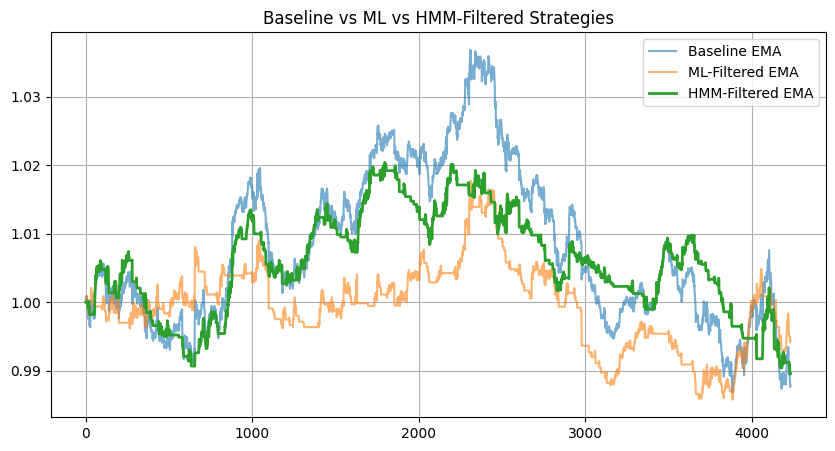

In [12]:
os.makedirs("../plots", exist_ok=True)

plt.figure(figsize=(10,5))
plt.plot(df["Cumulative_Return"], label="Baseline EMA", alpha=0.6)
plt.plot(df["ML_Cumulative"], label="ML-Filtered EMA", alpha=0.6)
plt.plot(df["HMM_Cumulative"], label="HMM-Filtered EMA", linewidth=2)

plt.legend()
plt.title("Baseline vs ML vs HMM-Filtered Strategies")
plt.grid(True)

plt.savefig("../plots/baseline_vs_ml_vs_hmm.png", dpi=300, bbox_inches="tight")
plt.show()


In [13]:
df.to_csv("../data/hmm_strategy_results.csv", index=False)

print("HMM regime analysis and outlier detection completed successfully")


HMM regime analysis and outlier detection completed successfully
